In [1]:
%load_ext autoreload
%autoreload 2

In [178]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from model import ReachabilityModel

#### Create Array of Pandas Dataframes for each CSV File in Dataset

In [3]:
dfs = []
datapath = os.getcwd() + '\data'
for item in os.listdir(datapath):
    fullpath = os.path.join(datapath, item)
    if os.path.isfile(fullpath):
        dfs.append(pd.read_csv('data/' + item))

C:\Users\cwphu\AppData\Local\Temp\ipykernel_26232\3426312423.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv('data/' + item))


#### Clean Each Input/Output DF and Generate Player Name -> Player ID Dictionary

In [4]:
def cleanInputData(df):
    cleandf = df.copy()
    cleandf = cleandf[cleandf['player_to_predict']==True]
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    cleandf = cleandf.drop(columns=['game_id', 'play_id', 'player_to_predict', 'player_birth_date', 'player_position'])
    cleandf['v_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['v_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['a_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['a_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf = cleandf.drop(columns=['s', 'a', 'dir'])
    return cleandf

def cleanOutputData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    cleandf = cleandf.drop(columns=['game_id', 'play_id'])
    return cleandf

In [5]:
clean_input_dfs = []
for i in range(0, 18):
    clean_input_dfs.append(cleanInputData(dfs[i]))
clean_output_dfs = []
for i in range(18, 36):
    clean_output_dfs.append(cleanOutputData(dfs[i]))

In [6]:
player_dict = dict()
max_play_len = 0
for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        id = row['nfl_id']
        max_play_len = max(max_play_len, row['frame_id'])
        if id not in player_dict:
            name = row['player_name']
            player_dict[id] = name

In [7]:
player_dict

{46137: 'Justin Reid',
 52546: "L'Jarius Sneed",
 44930: 'Josh Reynolds',
 44888: 'Alex Anzalone',
 55910: 'Brian Branch',
 53953: 'Jerry Jacobs',
 54653: 'Malcolm Rodriguez',
 41325: 'Jerick McKinnon',
 53591: 'Noah Gray',
 47882: 'Mike Edwards',
 38696: 'Marvin Jones',
 53487: 'Nick Bolton',
 53541: 'Amon-Ra St. Brown',
 54527: 'Bryan Cook',
 52471: 'Willie Gay Jr.',
 54568: 'Leo Chenal',
 47888: 'C.J. Gardner-Johnson',
 44906: 'Cameron Sutton',
 54562: 'Kerby Joseph',
 46213: 'Justin Watson',
 55882: 'Jack Campbell',
 46243: 'Marquez Valdes-Scantling',
 55920: 'Rashee Rice',
 53959: 'Brock Wright',
 54486: 'Trent McDuffie',
 52585: 'Michael Danna',
 55899: 'Sam LaPorta',
 55876: 'Jahmyr Gibbs',
 54511: 'Joshua Paschal',
 47913: 'Drue Tranquill',
 46309: 'Richie James',
 42460: 'Blake Bell',
 55895: 'Felix Anudike-Uzomah',
 54600: 'Joshua Williams',
 53449: 'Kadarius Toney',
 54716: 'Isiah Pacheco',
 54519: 'Skyy Moore',
 43584: 'Kalif Raymond',
 44834: 'Charles Harris',
 52440: 'Cly

In [8]:
max_play_len

123

#### Generate Input/Output Dataset for Justin Reid

In [392]:
player_id = 46137 # Justin Reid's NFL ID is 46137
justin_reid_input = dict()
justin_reid_output = dict()
justin_reid_labels = dict()

for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        if row['nfl_id'] == player_id:
            id = row['unique_play_id']
            data = np.array([row['x'], row['y'], row['o'], row['v_x'], row['v_y'], row['a_x'], row['a_y']])
            if id not in justin_reid_input:
                justin_reid_input[id] = [data]
                justin_reid_output[id] = np.array([row['num_frames_output'], row['ball_land_x'], row['ball_land_y']])
                justin_reid_labels[id] = np.array([False])
            else:
                justin_reid_input[id].append(data)

for clean_dfs in clean_output_dfs:
    for _,row in clean_dfs.iterrows():
        if row['nfl_id'] == player_id:
            id = row['unique_play_id']
            data = np.array([row['frame_id'], row['x'], row['y']])
            if id not in justin_reid_output:
                print("Dataset Error, no corresponding play ID in input dataframe")
            else:
                justin_reid_output[id] = np.vstack((justin_reid_output[id], data))
                justin_reid_labels[id] = np.append(justin_reid_labels[id], True)
                land_info = justin_reid_output[id][0]
                landx = land_info[1]
                landy = land_info[2]
                if ((abs(landx-row['x'])<1) and (abs(landy-row['y'])<1)):
                    justin_reid_labels[id][0] = True

In [393]:
justin_reid_input['2023090700101']

[array([5.13200000e+01, 2.06900000e+01, 2.67680000e+02, 3.04739775e-01,
        5.68653651e-02, 4.81685450e-01, 8.98839642e-02]),
 array([ 5.13500000e+01,  2.06600000e+01,  2.68660000e+02,  3.17654412e-01,
        -1.69397977e-01,  6.52956291e-01, -3.48206953e-01]),
 array([ 51.39      ,  20.63      , 269.78      ,   0.3326258 ,
         -0.28802791,   0.57453548,  -0.49750275]),
 array([ 51.43      ,  20.61      , 269.78      ,   0.34236022,
         -0.33643645,   0.44221528,  -0.43456374]),
 array([ 51.48      ,  20.58      , 269.06      ,   0.41493343,
         -0.34558682,   0.3380939 ,  -0.28158926]),
 array([ 5.15800000e+01,  2.06300000e+01,  2.74000000e+02,  6.01493056e-01,
        -1.01518981e-01,  2.85955715e-01, -4.82631221e-02]),
 array([ 5.16500000e+01,  2.06200000e+01,  2.74900000e+02,  6.82024308e-01,
        -1.04608044e-01,  4.84336103e-01, -7.42868716e-02]),
 array([ 5.17300000e+01,  2.06000000e+01,  2.77780000e+02,  8.65265740e-01,
        -9.06377338e-02,  1.0045039

In [394]:
justin_reid_output['2023090700101']

array([[21.        , 63.25999832, -0.22      ],
       [ 1.        , 56.22      , 17.28      ],
       [ 2.        , 56.63      , 16.88      ],
       [ 3.        , 57.06      , 16.46      ],
       [ 4.        , 57.48      , 16.02      ],
       [ 5.        , 57.91      , 15.56      ],
       [ 6.        , 58.34      , 15.1       ],
       [ 7.        , 58.75      , 14.57      ],
       [ 8.        , 59.14      , 14.01      ],
       [ 9.        , 59.51      , 13.41      ],
       [10.        , 59.86      , 12.8       ],
       [11.        , 60.19      , 12.15      ],
       [12.        , 60.5       , 11.46      ],
       [13.        , 60.78      , 10.75      ],
       [14.        , 61.05      , 10.02      ],
       [15.        , 61.32      ,  9.26      ],
       [16.        , 61.59      ,  8.48      ],
       [17.        , 61.84      ,  7.69      ],
       [18.        , 62.1       ,  6.9       ],
       [19.        , 62.36      ,  6.13      ],
       [20.        , 62.61      ,  5.38 

In [395]:
justin_reid_labels['2023090700101']

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

#### Pad Dataset Such that all Input Sequences are of Same Length

In [396]:
max_seq_len = 0
for key in justin_reid_input.keys():
    max_seq_len = max(max_seq_len, len(justin_reid_input[key]))
print(max_seq_len)

54


In [397]:
padded_justin_reid_input = dict()
for key in justin_reid_input.keys():
    pad_len = max_play_len - len(justin_reid_input[key])
    x = justin_reid_input[key][0][0]
    y = justin_reid_input[key][0][1]
    o = justin_reid_input[key][0][2]
    vx = justin_reid_input[key][0][3]
    vy = justin_reid_input[key][0][4]
    ax = justin_reid_input[key][0][5]
    ay = justin_reid_input[key][0][6]
    dt = 0.1
    start_x = x + vx*dt + 0.5*ax*dt**2
    start_y = y + vy*dt + 0.5*ay*dt**2
    padding = np.array([start_x, start_y, o, 0, 0, 0, 0])
    padding = np.tile(padding, (pad_len, 1))
    pad_data = np.concatenate((padding, justin_reid_input[key]))
    padded_justin_reid_input[key] = pad_data


In [398]:
training_ex = torch.from_numpy(padded_justin_reid_input['2023090700361'])
training_ex.shape

torch.Size([123, 7])

#### Generate Torch Training Tensors

In [421]:
input_sequences = []
input_destinations = []
output_sequences = []
output_label = []

oversample_ratio = 3

for key in justin_reid_input.keys():
    input_seq = padded_justin_reid_input[key]
    output_seq = justin_reid_output[key]
    labels = justin_reid_labels[key]

    for i in range(oversample_ratio):
        input_sequences.append(input_seq)
        input_destinations.append(output_seq[0])
        output_sequences.append(output_seq[1:])
        output_label.append(labels[0])

    rand_timestamps = np.random.randint(1, len(output_seq), len(output_seq)//2)
    for timestamp in rand_timestamps:
        input_sequences.append(input_seq)
        input_destinations.append(output_seq[timestamp])
        output_sequences.append(output_seq[1:])
        output_label.append(labels[timestamp])
    

In [422]:
output_frequency = {}

for item in output_label:
    if item in output_frequency:
        output_frequency[item] += 1
    else:
        output_frequency[item] = 1

for value, count in output_frequency.items():
    print(f"Value: {value}, Frequency: {count}")

Value: False, Frequency: 333
Value: True, Frequency: 793


In [423]:
input_seq_tensor = torch.from_numpy(np.array(input_sequences))
input_seq_tensor = input_seq_tensor.to(torch.float32)
print(input_seq_tensor.shape)
input_target_tensor = torch.from_numpy(np.array(input_destinations))
input_target_tensor = input_target_tensor.to(torch.float32)
print(input_target_tensor.shape)
output_tensor = torch.tensor(output_label)
output_tensor = torch.unsqueeze(output_tensor, 1)
output_tensor = output_tensor.to(torch.float32)
print(output_tensor.shape)
print(len(output_sequences))

torch.Size([1126, 123, 7])
torch.Size([1126, 3])
torch.Size([1126, 1])
1126


#### Training Loop

In [424]:
batch_size = 32
num_epochs = 50
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [425]:
dataset = list(zip(input_seq_tensor, input_target_tensor, output_tensor))

# --- Train/Validation Split ---
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [426]:
model = ReachabilityModel(
    motion_input_dim=7, lstm_hidden_dim=32, fc_hidden_dim=32
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_acc = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    total, correct = 0, 0
    for seq_tensor, target_tensor, batch_output in train_loader:
        seq_tensor = seq_tensor.to(device)
        target_tensor = target_tensor.to(device)
        batch_output = batch_output.to(device)

        # Forward pass
        y_pred = model(seq_tensor, target_tensor)
        loss = criterion(y_pred.squeeze(), batch_output.squeeze())
        preds = (y_pred > 0.5).float()
        correct += (preds == batch_output).sum().item()
        total += batch_output.numel()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader.dataset)
    avg_train_acc = correct / total
    train_acc.append(avg_train_acc)

    # --- Validation phase ---
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for seq_tensor, target_tensor, batch_output in val_loader:
            seq_tensor = seq_tensor.to(device)
            target_tensor = target_tensor.to(device)
            batch_output = batch_output.to(device)

            y_pred = model(seq_tensor, target_tensor)
            preds = (y_pred > 0.5).float()
            correct += (preds == batch_output).sum().item()
            total += batch_output.numel()

            all_preds.append(preds.cpu())
            all_labels.append(batch_output.cpu())


    avg_val_acc = correct / total
    val_acc.append(avg_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {avg_train_acc:.4f} | "
          f"Val Acc: {avg_val_acc:.4f} | ")

Epoch [1/50] Train Loss: 0.0128 | Train Acc: 0.5622 | Val Acc: 0.6845 | 
Epoch [2/50] Train Loss: 0.0112 | Train Acc: 0.6726 | Val Acc: 0.6845 | 
Epoch [3/50] Train Loss: 0.0104 | Train Acc: 0.6853 | Val Acc: 0.6786 | 
Epoch [4/50] Train Loss: 0.0103 | Train Acc: 0.6739 | Val Acc: 0.6786 | 
Epoch [5/50] Train Loss: 0.0101 | Train Acc: 0.6916 | Val Acc: 0.6786 | 
Epoch [6/50] Train Loss: 0.0097 | Train Acc: 0.7081 | Val Acc: 0.6786 | 
Epoch [7/50] Train Loss: 0.0099 | Train Acc: 0.7005 | Val Acc: 0.6786 | 
Epoch [8/50] Train Loss: 0.0098 | Train Acc: 0.6967 | Val Acc: 0.6845 | 
Epoch [9/50] Train Loss: 0.0099 | Train Acc: 0.6954 | Val Acc: 0.6845 | 
Epoch [10/50] Train Loss: 0.0095 | Train Acc: 0.7094 | Val Acc: 0.6845 | 
Epoch [11/50] Train Loss: 0.0098 | Train Acc: 0.6942 | Val Acc: 0.6845 | 
Epoch [12/50] Train Loss: 0.0096 | Train Acc: 0.7043 | Val Acc: 0.6845 | 
Epoch [13/50] Train Loss: 0.0096 | Train Acc: 0.7094 | Val Acc: 0.7083 | 
Epoch [14/50] Train Loss: 0.0094 | Train Acc: 0

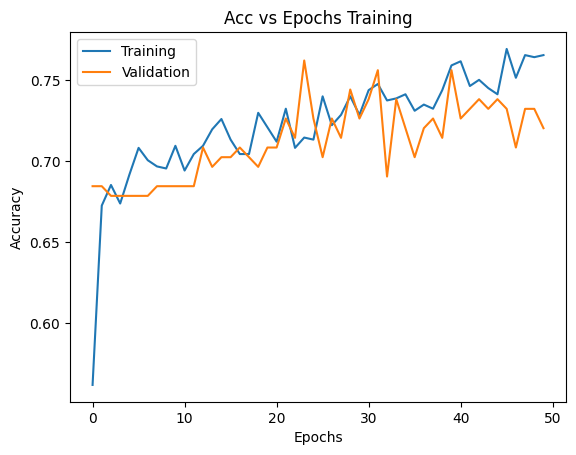

In [428]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Acc vs Epochs Training')
plt.show()

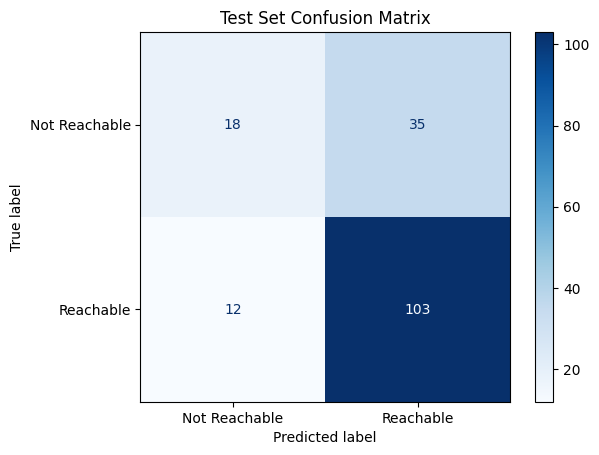

In [429]:
model.eval()
total, correct = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for seq_tensor, target_tensor, batch_output in val_loader:
        seq_tensor = seq_tensor.to(device)
        target_tensor = target_tensor.to(device)
        batch_output = batch_output.to(device)

        y_pred = model(seq_tensor, target_tensor)
        preds = (y_pred > 0.5).float()
        correct += (preds == batch_output).sum().item()
        total += batch_output.numel()

        all_preds.append(preds.cpu())
        all_labels.append(batch_output.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Reachable", "Reachable"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.show()

#### Probabilistic Gaussian Modeling

In [430]:
id = 40

eg_input = input_seq_tensor[id]
eg_target = input_target_tensor[id]
eg_output = output_tensor[id]
eg_outseq = output_sequences[id]

In [431]:
eg_input

tensor([[ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5407e+01,  1.8113e+01,  9.5960e+01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 

In [432]:
landx = eg_target[1].item()
landy = eg_target[2].item()
marker = 'x' if eg_output == 0 else 'o'
print(eg_target)
print(marker)

trajectx_before = []
trajecty_before = []
trajectx_after = []
trajecty_after = []
for point in eg_input:
    trajectx_before.append(point[0].numpy())
    trajecty_before.append(point[1].numpy())
for point in eg_outseq:
    trajectx_after.append(point[1])
    trajecty_after.append(point[2])

centerx = int(eg_input[-1][0].item())
centery = int(eg_input[-1][1].item())
print(eg_input[-1])

startx = max(centerx-15, 0)
endx = min(centerx+15, 120)
starty = max(centery-15, 0)
endy = min(centery+15, 53)

tensor([12.0000, 52.9600, 15.2400])
x
tensor([ 6.1580e+01,  1.2710e+01,  3.4269e+02, -5.2295e+00, -1.4621e+00,
        -1.0690e+00, -2.9887e-01])


In [433]:
targets = []
coords_x = []
coords_y = []
for i in range(startx, endx):
    for j in range(starty, endy):
        targets.append([10.0, i, j])
        coords_x.append(i)
        coords_y.append(j)
targets = torch.tensor(targets)
coords_x = np.array(coords_x)
coords_y = np.array(coords_y)

In [434]:
eg_input_list = [eg_input for _ in range(len(targets))]
stacked_eg_input = torch.stack(eg_input_list, dim=0)
stacked_eg_input.shape

torch.Size([810, 123, 7])

In [435]:
probs = []
model.eval()
with torch.no_grad():
    probs = model(stacked_eg_input.to(device), targets.to(device))
probs = torch.squeeze(probs).cpu().numpy()

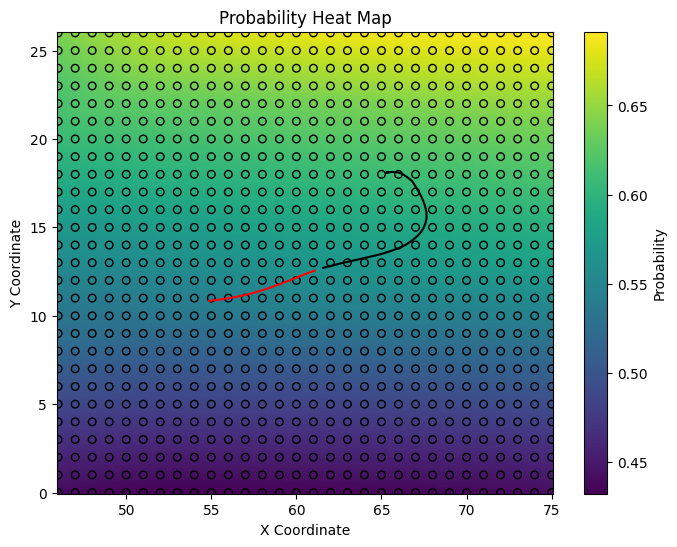

In [436]:
# Create a regular grid to interpolate the data
xi = np.linspace(min(coords_x), max(coords_x), 200)
yi = np.linspace(min(coords_y), max(coords_y), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate using griddata (cubic gives smoother results)
zi = griddata((coords_x, coords_y), probs, (xi, yi), method='cubic')

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.pcolormesh(xi, yi, zi, cmap='viridis', shading='auto')
plt.scatter(coords_x, coords_y, c=probs, cmap='viridis', edgecolors='k', s=30)  # optional: overlay original points
plt.colorbar(heatmap, label='Probability')
plt.plot(trajectx_before, trajecty_before, color='k')
plt.plot(trajectx_after, trajecty_after, color='r')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Probability Heat Map')
plt.show()